> > #  retinopathy convNet Case2 (with convNet + dense)
Lauri Solin 
[Helsinki Metropolia University of Applied Sciences](www.metropolia.fi/en)<br>

## Xception convNet and dense, for binary classification retinopathy

Make a convnet architecture and try to classify images to predict diabetic retinopathy in binary fashion (sick or healthy).

I will attempt to use pre-trained Xception convNet, but I will initialize it to random weights and try different training schemes.

Earlier tests I tried to do with underfitting architectures, but ready convNets such as Xception of VGG19 should be powerful enough for the retinopathy classification. You should always try to first get an overfitting model with good trainingaccuracy in my limited experience. That way you can see that the model is overfitting and is powerful enough to learn the trainingset, even if the validationaccuracy is lagging behind.

1.) maybe and train convLayer parts of the network for a few epochs

2.) Then, I will freeze that convNet layers, then I will train the dense layers only (???)

3.) possibly initalize random and train the whole convNet + dense. (easiest to do)


## useful links & resources
* here was a useful tutorial for imagegenerators and pre-trained convnet https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e
* another good help link https://github.com/keras-team/keras/issues/4465
* Im trying to use pretrained convnet architecture such that not the  entirety of my days on this earth are spent on convNet model training
* we will see what kind of results we get
* After having tried most tips, the last one I didn't use (yet)  was to crop the images into larger size, this appears to be necessary to achieve good results
* more good links for help especially the file preprocessing and the imagecropping portions early on (its difficult to learn this file processing part if you're not good in python already)

https://www.kaggle.com/hooseygoose/directory-structure-and-moving-files


http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html


https://www.kaggle.com/sakarilukkarinen/demo-11-xception-and-dense-2


https://www.kaggle.com/markupik/case2-retinopathy


https://www.kaggle.com/sakarilukkarinen/demo-04-binary-classifier

## basic procedures to do 
1. sample the eyeimages's labels into dataframes randomly
2. upsize the images into 299x299 size
3. make imageDataGenerators for trainingset, validationset (and testsets possibly trainingset? its tedious to create those file directories though)
4. import Xception convNet and add some layers into it
5. train model (it will take long time)
6. plot accuracy and roc metrics, and also make tests with the testset (testset images would have to be cropped also, very tedious...)

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications import VGG19
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers
import os, shutil, cv2, time



Using TensorFlow backend.


In [2]:
"""Initial settings for training/validation, remember to choose!!!"""
EPOCHS = 30
BATCHSIZE = 16
TRAINSET_PERCENT = 0.75 ## percentage of trainingset from totalsamples (from [0, 1.0] )
SAMPLES = 4000  ## take huge sample of images, but only train&validate on subsets of allowed trainable/validatable images
TRAINSTEPS_PERCENT = 1.0  ## percentage of trainingset steps being done (from [0, 1.0] )
VALIDSTEPS_PERCENT = 1.0  ## percentage of validationset steps being done (from [0, 1.0] )
BALANCEDSET = False ## balance the df dataset 50:50 sick/healthy, otherwise simply random sample 
MODELNAME = "borrowedXceptionArchitecture" + ".h5"
trainConvLayers = True  ## train convLayers or freeze them
SEED = 1999-888
ROTANGLE = 10
ZOOM = 0.02
VERBOSE = 1  ## for modeltraining
IMAGESIZE = 299



source_dir = r"../input/preprocessed-diabetic-retinopathy-trainset/300_train/300_train/"
temp_dir = r"./temp/"
#test_dir = r"../input/300_test/300_test/"

# initialize multiple optimizers but you can only choose one at a time of course!
sgd = optimizers.SGD(lr=0.01/2, decay=1e-6, momentum=0.9, nesterov=True)
addyboi = optimizers.Adam(lr=0.01, decay=1e-5)
rmsprop = optimizers.RMSprop(lr=0.01/2)
basic_rms = optimizers.RMSprop()

"""remember to choose optimizer!!!"""
OPTIMIZER = basic_rms

In [3]:
# Convert categorical level to binary and randomly sample
import numpy as np
df = pd.read_csv(r"../input/preprocessed-diabetic-retinopathy-trainset/newTrainLabels.csv")
df['level'] = 1*(df['level'] > 0)

# balance classes
if BALANCEDSET:
    print('balancing dataset...')
    df = pd.concat([
        df[df['level']==0].sample(n=round(SAMPLES/2.0), random_state=SEED),
        df[df['level']==1].sample(n=round(SAMPLES/2.0), random_state=SEED)
    ]).sample(frac=1.0, random_state=SEED) # shuffle
else:
    print('raw dataset(unbalanced)...')
    df= df.sample(n=SAMPLES, random_state=SEED)


df.reset_index(drop=True, inplace=True) # I've had troubles with shuffled dataframes on some earlier Cognitive Mathematics labs,
                                        # and this seemed to prevent those
print(df.head())
print("")

raw dataset(unbalanced)...
         image  level        MB
0    1032_left      1  0.174547
1  39637_right      0  0.160022
2    7677_left      0  0.125897
3  27912_right      0  0.152749
4   5435_right      1  0.173700



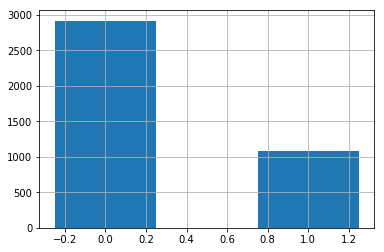

In [4]:


# Create level histogram
df['level'].hist(bins = [0,1, 2], rwidth = 0.5, align = 'left');



In [5]:
# here we can split df into train/validation dataframes, and then we can use
# separated imagedatagenerators, such that we are able to use data augmentation 
# for only the traindata images
# the validdata images should be left raw as they are

setBoundary = round(SAMPLES * TRAINSET_PERCENT)
train_df = df[:setBoundary]
validate_df = df[setBoundary:]
train_df.reset_index(drop=True, inplace=True)
validate_df.reset_index(drop=True, inplace=True)

In [6]:
# Here the issue with original demo4 code from Sakari was that there was the typeError from imageDataGenerators
# at least for myself, so that the error message suggested that I should convert level column to str
df["level"]= df.iloc[:,1].astype(str)
train_df["level"]= train_df.iloc[:,1].astype(str)
validate_df["level"]= validate_df.iloc[:,1].astype(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
#Test out images can be found
image_path = source_dir + df["image"][0] +".jpeg"
if  os.path.isfile(image_path)==False:
    raise Exception('Unable to find train image file listed on dataframe')
else:
    print('Train data frame and file path ready')
    

Train data frame and file path ready


In [8]:
# Prepare to crop images to larger size so that the network can work on them...
# apparently too small images are just shit for these convNeuralNetworks
# Create destination directory

try:
    os.mkdir(temp_dir)
    print('Created a directory:', temp_dir)
except:
    # Temp directory already exist, so clear it
    for file in os.listdir(temp_dir):  
        file_path = os.path.join(temp_dir, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
    print(temp_dir, ' cleared.')

Created a directory: ./temp/


In [9]:
# Crop the images to larger size from 100x100 upwards to atleast 300x300 
# some contestant winner had images 500x500
# I've tried this vgg19 with 100x100 and it was not good results

# Start timing
start = time.time()

# Crop and resize all images. Store them to dest_dir
print("Cropping and rescaling the images:")
for i, file in enumerate(df["image"]):
    try:
        fname = source_dir + file + ".jpeg"
        img = cv2.imread(fname)
    
        # Crop the image to the height
        h, w, c = img.shape
        if w > h:
            wc = int(w/2)
            w0 = wc - int(h/2)
            w1 = w0 + h
            img = img[:, w0:w1, :]
        # Rescale to N x N
        N = IMAGESIZE
        img = cv2.resize(img, (N, N))
        # Save
        new_fname = temp_dir  + file + ".jpeg"
        cv2.imwrite(new_fname, img)
    except:
        # Display the image name having troubles
        print("problemImagesFound:___ ", fname)
         
    # Print the progress for every N images
    if (i % 500 == 0) & (i > 0):
        print('{:} images resized in {:.2f} seconds.'.format(i, time.time()-start))

# End timing
print('Total elapsed time {:.2f} seconds.'.format(time.time()-start))
print('temp_dir was=' + temp_dir)

Cropping and rescaling the images:
500 images resized in 5.84 seconds.
1000 images resized in 11.39 seconds.
1500 images resized in 16.94 seconds.
2000 images resized in 22.56 seconds.
2500 images resized in 27.96 seconds.
3000 images resized in 33.56 seconds.
3500 images resized in 39.22 seconds.
Total elapsed time 44.75 seconds.
temp_dir was=./temp/


In [10]:
path0= temp_dir # specify directory where the f***ing files are
fileList = os.listdir(path0) # get the f***ing file list in the path directory
# list files
print(fileList[0])# print if you even found any f***ing files in this f***ing kaggle environment

37728_right.jpeg


In [11]:
for i in range (5):
    print(df['image'][i])

1032_left
39637_right
7677_left
27912_right
5435_right


In [12]:
# We must convert the dataframes's image columns into .jpeg extension, so generators can find images into the dataframes
"""wtf is wrong with this code, why kaggle keeps raising warnings
why it is suddenly illegal to MODIFY the goddamn column to have ".jpeg" in the end for all values?!"""

print(df.head(5))
a=df.iloc[:,0] + ".jpeg"
b=train_df.iloc[:,0] + ".jpeg"
c=validate_df.iloc[:,0] + ".jpeg"
df['image']=a
train_df['image']=b
validate_df['image']=c
print(df.head(5))

         image level        MB
0    1032_left     1  0.174547
1  39637_right     0  0.160022
2    7677_left     0  0.125897
3  27912_right     0  0.152749
4   5435_right     1  0.173700
              image level        MB
0    1032_left.jpeg     1  0.174547
1  39637_right.jpeg     0  0.160022
2    7677_left.jpeg     0  0.125897
3  27912_right.jpeg     0  0.152749
4   5435_right.jpeg     1  0.173700


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# Create image data generator
from keras.preprocessing.image import ImageDataGenerator
# I think that it would be possible also to use data augmentation in the training_generator only.
# Also the interview of kaggle contestants showed my own suspicions to be true that one should not use 
# image shear with eye data (the perfectly healthy human eyeball should be round, so you dont get eyeglasses)
# those contestant used rotation and mirrorings of the image as I recall, but small amounts of
#  zoom would not be too bad either, I reckon

# use data augmentation for training
traingen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=ROTANGLE,
    zoom_range=ZOOM,
    horizontal_flip=True,
    vertical_flip=True)

## just take the raw data for validation
validgen = ImageDataGenerator(
    rescale=1./255)

# Data flow for training
trainflow = traingen.flow_from_dataframe(
    dataframe = train_df, 
    directory = temp_dir,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", # class_mode binary causes to infer classlabels automatically from y_col, at least according to keras documentation
    target_size = (IMAGESIZE, IMAGESIZE), 
    batch_size = BATCHSIZE,
    shuffle = True,
    seed = SEED)

# Data flow for validation
validflow = validgen.flow_from_dataframe(
    dataframe = validate_df, 
    directory = temp_dir,
    x_col = "image", 
    y_col = "level", 
    class_mode = "binary", 
    target_size = (IMAGESIZE, IMAGESIZE), 
    batch_size = BATCHSIZE,
    shuffle = False, # validgen doesnt need shuffle I think, according to teacher's readymade convnet example (?)
#    seed = SEED
)



Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
"""## We will try Juha Kopus model style for pre-trained VGG16. it was pretty bad in my opinoin, i tested it
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dropout(0.3, seed=SEED)(x) # add dropout just in case
x = Dense(256,activation='relu')(x)
x = Dropout(0.3, seed=SEED)(x) # add dropout just in case
preds = Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation"""
"""## Sakaris Xception model style for Xception convnet ##
## with added Dense model at the end of ConvNet"""
"""x = base_model.output ##this was some old code to make for MobileNet from example tutorial about convnets
x = GlobalAveragePooling2D()(x)
x = Flatten(name='flatten')(x)
x=Dropout(0.2, seed=SEED)(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.3, seed=SEED)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.3, seed=SEED)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(0.3, seed=SEED)(x)
preds=Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation
"""



"x = base_model.output ##this was some old code to make for MobileNet from example tutorial about convnets\nx = GlobalAveragePooling2D()(x)\nx = Flatten(name='flatten')(x)\nx=Dropout(0.2, seed=SEED)(x)\nx=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.\nx=Dropout(0.3, seed=SEED)(x)\nx=Dense(1024,activation='relu')(x) #dense layer 2\nx=Dropout(0.3, seed=SEED)(x)\nx=Dense(512,activation='relu')(x) #dense layer 3\nx=Dropout(0.3, seed=SEED)(x)\npreds=Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation\n"

In [15]:

from keras.applications.xception import Xception

base_model = Xception(include_top=False, input_shape=(IMAGESIZE, IMAGESIZE, 3)) # randomized initial weights, Xception_base

if not trainConvLayers:
    for layer in base_model.layers: # make convLayers un-trainable
        layer.trainable=False        
        
base_model.summary()

x = base_model.output

x = GlobalAveragePooling2D()(x)  
#x = Flatten(name='flatten')(x)  
x = Dropout(0.25, seed=SEED)(x) # add dropout just in case      
x = Dense(512, activation='relu')(x)
x = Dropout(0.4, seed=SEED)(x) # add dropout just in case      
x = Dense(512, activation='relu')(x)
x = Dropout(0.4, seed=SEED)(x) # add dropout just in case  
x = Dense(256,activation='relu')(x)
x = Dropout(0.4, seed=SEED)(x) # add dropout just in case
preds = Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation

model=Model(inputs=base_model.input,outputs=preds)
#for i,layer in enumerate(model.layers):
#    print(i,layer.name)

print(model.summary())

model.compile(optimizer = OPTIMIZER,
             loss='binary_crossentropy', 
              metrics = ["accuracy"])

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________

In [16]:

from keras.callbacks import ModelCheckpoint
from time import time, localtime, strftime
# Testing with localtime and strftime
print(localtime())
print(strftime('%Y-%m-%d-%H%M%S', localtime()))


# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = round((trainflow.n // trainflow.batch_size) * 1.0 * TRAINSTEPS_PERCENT ) 
STEP_SIZE_VALID = round((validflow.n // validflow.batch_size) * 1.0 * VALIDSTEPS_PERCENT ) 

# Train and count time
model_name = strftime('Case2-%Y-%m-%d-%H%M%S', localtime()) + MODELNAME
print('modelname was=',model_name,'\n')

t1 = time()
h = model.fit_generator(generator = trainflow,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = validflow,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    verbose = VERBOSE)
t2 = time()
elapsed_time = (t2 - t1)

# Save the model
model.save(model_name)
print('')
print('Model saved to file:', model_name)
print('')

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/EPOCHS))
print('Total elapsed time for {:d} epochs: {:s}'.format(EPOCHS, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))



time.struct_time(tm_year=2019, tm_mon=3, tm_mday=5, tm_hour=21, tm_min=1, tm_sec=37, tm_wday=1, tm_yday=64, tm_isdst=0)
2019-03-05-210137
modelname was= Case2-2019-03-05-210137borrowedXceptionArchitecture.h5 

Epoch 1/30
187/187 [==============================] - 278s 1s/step - loss: 0.6159 - acc: 0.7313 - val_loss: 4.4845 - val_acc: 0.7218
Epoch 2/30
187/187 [==============================] - 263s 1s/step - loss: 0.6020 - acc: 0.7293 - val_loss: 2.0884 - val_acc: 0.7226
Epoch 3/30
187/187 [==============================] - 261s 1s/step - loss: 0.5953 - acc: 0.7326 - val_loss: 0.6852 - val_acc: 0.7215
Epoch 4/30
187/187 [==============================] - 261s 1s/step - loss: 0.5978 - acc: 0.7310 - val_loss: 0.5940 - val_acc: 0.7205
Epoch 5/30
187/187 [==============================] - 261s 1s/step - loss: 0.5870 - acc: 0.7313 - val_loss: 0.7125 - val_acc: 0.7236
Epoch 6/30
187/187 [==============================] - 262s 1s/step - loss: 0.5864 - acc: 0.7293 - val_loss: 2.1727 - val_acc:

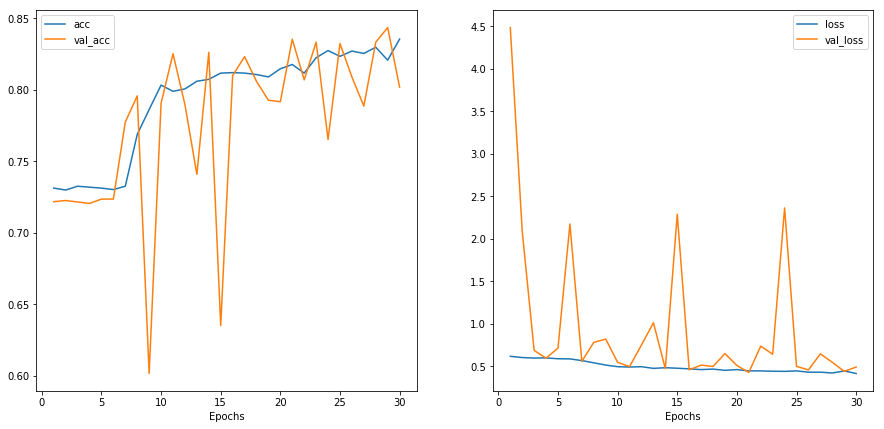

In [17]:
# get the currently trained model, and plot the accuracies and loss for training and validation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(EPOCHS) + 1.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))

def plotter(ax, epochs, h, variable):
    ax.plot(epochs, h.history[variable], label = variable)
    ax.plot(epochs, h.history['val_' + variable], label = 'val_'+variable)
    ax.set_xlabel('Epochs')
    ax.legend()

plotter(ax1, epochs, h, 'acc')
plotter(ax2, epochs, h, 'loss')
plt.show()




In [18]:
# get true values
y_true = validflow.classes
# note about predict_generator, 
# sometimes it happened that, if you put argument steps = STEP_SIZE_VALID, then
# that throws error because of mismatched steps amount somewhere, I think that the
# np.ceil(validgen.n/validgen.batch_size) seems to fix it
predict = model.predict_generator(validflow, steps= np.ceil(validflow.n / validflow.batch_size))
y_pred = 1*(predict > 0.5)

In [19]:

# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Lates Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, y_pred)
print('Lates Classification report:')
print(cr)
print('')

from sklearn.metrics import accuracy_score
a = accuracy_score(y_true, (y_pred))
print(a)
print('Lates Accuracy with old decision point {:.4f} ==> {:.4f}'.format(0.5, a))
print('')


Lates Confusion matrix:
[[549 174]
 [224  53]]

Lates Classification report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       723
           1       0.23      0.19      0.21       277

   micro avg       0.60      0.60      0.60      1000
   macro avg       0.47      0.48      0.47      1000
weighted avg       0.58      0.60      0.59      1000


0.602
Lates Accuracy with old decision point 0.5000 ==> 0.6020



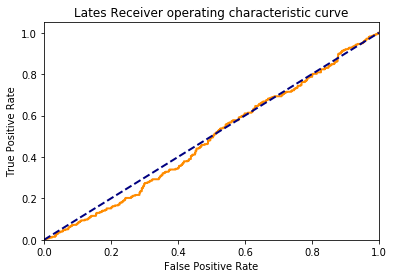

In [20]:

# Calculate and plot ROC-curve
# See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, predict) 

plt.plot(fpr, tpr, color='darkorange', lw = 2)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lates Receiver operating characteristic curve')
plt.show()


Sakaris best model was as follows: 

Sakaris Confusion matrix:
[[630  93]
 [234  43]]

Sakaris Classification report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       723
           1       0.32      0.16      0.21       277

   micro avg       0.67      0.67      0.67      1000
   macro avg       0.52      0.51      0.50      1000
weighted avg       0.61      0.67      0.63      1000


0.673
Sakaris Accuracy with old decision point 0.5000 ==> 0.6730



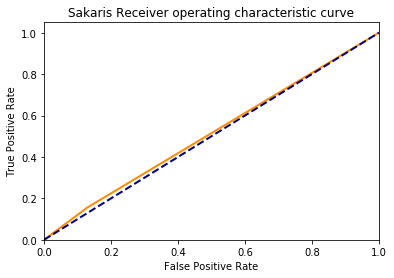

In [21]:
from keras.models import load_model

sakarismodel = load_model("../input/sakarisbestmodelxception/best_demo11_SAKARISDEMO11.h5")
predictSakari = sakarismodel.predict_generator(validflow, steps= np.ceil(validflow.n / validflow.batch_size))
y_predSakari = 1*(predictSakari > 0.5)

print('Sakaris best model was as follows: \n')
# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_predSakari)
print('Sakaris Confusion matrix:')
print(cm)
print('')

cr = classification_report(y_true, y_predSakari)
print('Sakaris Classification report:')
print(cr)
print('')

from sklearn.metrics import accuracy_score
a = accuracy_score(y_true, (y_predSakari))
print(a)
print('Sakaris Accuracy with old decision point {:.4f} ==> {:.4f}'.format(0.5, a))
print('')


fpr0, tpr0, thresholds0 = roc_curve(y_true, y_predSakari) 

plt.plot(fpr0, tpr0, color='darkorange', lw = 2)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sakaris Receiver operating characteristic curve')
plt.show()


In [22]:
# Clear the temporary directory
dest_dir = './temp/'
for file in os.listdir(dest_dir):
    file_path = os.path.join(dest_dir, file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)
print(dest_dir, ' cleared.')
os.rmdir(dest_dir)
print(dest_dir,'Removed.')

./temp/  cleared.
./temp/ Removed.


## Conclusions
In general, the benefits from this case2 to me was mostly about learning how to 
work with convnets, but the downside was that the predictive results and model were quite bad.

- I don't think it was possible to have good accuracies with small size images like 100x100 pre-processed dataset so that somehow the cropping and sizing-up the images seemed to make the crucial difference for the positive direction for model training/validation
- imagenet weights were tried in another notebook version with the VGG19 model, but those imagenet weights didnt seem to work so well, at least with the 100x100 images
- possibly it would have been best to utilize randomized weights for VGG19 and train the convLayers at least for even few epochs, and then attempt to freeze the convLayers and continue to train the dense layers to save some time
- I tried to tweak the catsAndDogs model with dropouts, different learning rates, different optimizers and even increasing amounts of some convlayers and maxpools,
but it appears that the basic architecture was not good enough for our purposes. It must have been underfitting which would indicate that architecture was too simplistic for the job, I think.
- data augmentation was tried with zoom, rotation and image flippings, but the effect of data-augmentation did not stop model overfitting with basic Sakari's Xception architecture at least for myself.
- I read from wikipedia that the human eye size has about max 2% difference in adult eye size, and the medical eye images should be pretty "fixed in place" in terms of the eye position because the patient is putting his head into a cradle to fully stabilize the head during an eye examination. But perhaps the blood veins inside the eye are "rotated" from person to person when comparing?

- Xception convNet with dense, seemed to have good training and validation accuracies, but only 30 epochs were done for training. Perhaps that model could be better with larger trainingsets and more time spent on training the whole model. Maybe dropout could also be tweaked 




## Learning outcomes

* most important lesson in this case2 for me was that when faced with image recognition, first you must try to overfit your model, then you can tweak it later.
* second important lesson in this case2 was that if you want good results from actual testing, dont try to be a hero and re-invent the wheel, use ready convNet architectures at least first.
* I learned how to work within kaggle environment, which was nice because it offloaded that computation to the cloud, so you could think about your next plan while the kernels are committing/running
* later on, I read tutorial about how to use pre-trained convNet with keras and I managed to get some good results as soon as I cropped and upsized the images to about 299x299 from the old 100x100
* I think I finally understood a lot of how that keras functionality works such as the imageDataGenerators and flow_from_dataframe.
* gained more experience in working with the keras, because I had to read a lot into the documentation  (which parameters are there and what they do etc...)
* I learned how the kaggle workflow works best at least for me if you want to try the same basic setup, but with different keras parameter such as switching optimizers, batchsizes, learning rates etc...
* I also tested some basic style convnets such as the CIFAR-10 dataset model I introduced in the beginning, but the results were not good at least for me.
* probably with hindsight the best strategy from the very beginning would have been to start immediately in the kaggle environment, then take a good pretrained convnet like inception or Vgg19 and just use that. In that way you would learn how to use the pre-trained convnet and also get good results. 

## my kaggle workflow

1. create basic notebook kernel which has the model and initial setups done, including the getting the data and training model
2. put epochs to 3 and run the whole notebook so it checks if it will crash (it should not take huge amount of time with only small amount of epochs)
3. now you can estimate how long it will take per epoch and write it on paper or something
4. put epochs back to whatever you want, then save notebook to your local pc (for safety purposes)
5. Then you could maybe fork that kernel again, then use that forked kernel to commit that one
6. then you should still be able to fork that original kernel how many times you want and make commits of those ones, with whateve changes you want to apply
7. then you can pretty much wait until the kernels are committed in the cloud and do something else or ponder your next move
8. as mentioned earlier you get your saved models in the committed kernels output section, if you want to download your trained models to your pc